# **Assignment 2 - Language Models**
#### **Due: September 28, 2023, 11:59PM**

### **Notes**

### **Introduction**

Welcome to CSE 527A. Each assignment will contain two parts: a written and coding portion. The coding portion for each homework assignment will be delivered through a Colaboratory notebook such as this one. Please use as many code and markdown cells to run and explain all the steps you took in order to answer each question for each problem. Please keep in mind the collaboration policy as specified in the Academic Integrity section of the syllabus and cite all external sources and/or collaborators.

### **Comments/Documentation**

Please follow PEP 8 style guidelines (https://peps.python.org/pep-0008/) for commenting your code. Furthermore, please remember to manually save your work once in a while. If you are connected to a hosted runtime that if for whatever reason it disconnects you will have to rerun all connected code cells.

### **Getting Started**

In order to compile code efficiently, enable GPU support.

To access a GPU, go to `Edit->Notebook settings` and in the `Hardware accelerator` dropdown choose `GPU`.
As soon as you run a code cell, you will be connected to a cloud instance with a GPU.
Try running the code cell below to check that a GPU is connected (select the cell then either click the play button at the top left or press `Ctrl+Enter` or `Shift+Enter`).

The free version of Google Colab will provide the necessary hardware for this course. Please keep in mind the RAM and Disk Space that you are allocated and that you are not given an infinite active runtime.

### **Submission Instructions**

We will use Gradescope for assignment submission. Submit the written and code portions of the assignment to the respective assignments. **Please note if notebook output is cleared, you will receive a 0**. To download this notebook, go to `File->Download .ipynb`.

When submitting your ipython notebooks, make sure everything runs correctly if the cells are executed in order starting from a fresh session.  Note that just because a cell runs in your current session doesn't mean it doesn't rely on code that you have already changed or deleted.

Note that Gradesope will allow you to submit multiple times before the deadline, and we will use the latest submission for grading.

## **Setup**

In [ ]:
from google.colab import drive # one option to load datasets
from google.colab import files
drive.mount('/content/gdrive')
!nvidia-smi -L # check if using GPU

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# various imports you might find useful, feel free to import additional packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from torch import optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import tensorflow as tf

In [ ]:
! pip install datasets

In [ ]:

from datasets import load_dataset

# Load the dataset
trainset = load_dataset("wikitext", name="wikitext-2-v1", split="train")
valset = load_dataset("wikitext", name="wikitext-2-v1", split="validation")
testset = load_dataset("wikitext", name="wikitext-2-v1", split="test")

# Preprocess text
punctuation = list("~!@#$%^&*()_+`{}|\[\]\:\";\-\\\='<>?,./，。、《》？；：‘“{【】}|、！@#￥%……&*（）——+=-")
def preprocess(dataset):
  data = []
  for text in dataset['text']:
    # Ignore emtpy sentences
    if text == '':
      continue
    # Remove puncutation and unknown tokens
    tokens = [t for t in text.split() if t != '' and t not in punctuation and t != '<unk>']
    data.append(tokens)
  return data
traindata = preprocess(trainset)
valdata = preprocess(valset)
testdata = preprocess(testset)

# Problem 1
(Eisenstein Ch. 6) Using the Pytorch library, train an LSTM language model from the same Wikitext training corpus you used in problem 1. After each epoch of training, compute its perplexity on the Wikitext validation corpus. Stop training when the perplexity stops improving.

1. Fully describe your model architecture, hyperparameters, and experimental procedure.
2. After each epoch of training, compute your LM’s perplexity on the development data. Plot the development perplexity against # of epochs. Additionally, compute and report the perplexity on test
data.

**NOTE:** This may take some time, so you should start early. Also, you should use a GPU. When using PyTorch, you can move your model and data to the GPU with the following commands:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This is defined for you
model.to(device)
x = x.to(device)
```

**The PyTorch documentation is very good; I recommend reading it.**
Start here: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Good luck, and post on Piazza if you have any questions or see any errors.

### Starting Point
First, find the distribution of sentence length to decide the max-length for training RNN models.

In [ ]:
# Your code goes here
# train data is a list with a bunch of sentences in list, the total sentences are 23767
import matplotlib.pyplot as plt
import numpy as np



sentence_length = []

for sentence_list in traindata:
    sentence_length.append(len(sentence_list))




Maximum length of sentence is:  628
Average length of sentence is:  72.52333066857408


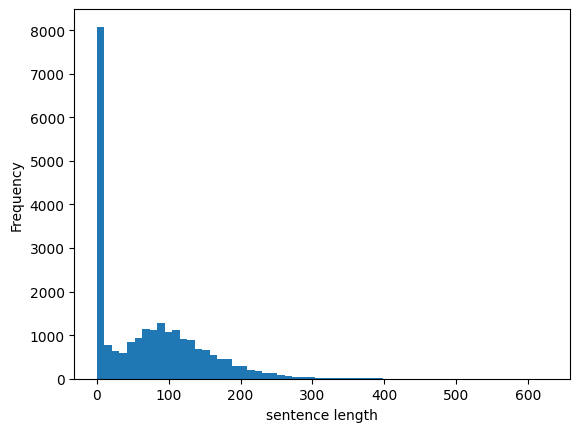

In [ ]:

plt.hist(sentence_length, bins = 60)
print("Maximum length of sentence is: ", np.max(sentence_length))
print("Average length of sentence is: ", np.mean(sentence_length))

plt.xlabel('sentence length')
plt.ylabel('Frequency')
plt.show()

Based on the above, choose the max-length for training RNN models.

In [ ]:
# TODO: select these values based on the above.
# MAXLEN = 628 # Maximum length of the input sentences
MAXLEN =  268 # 628 is running foreever and the performance is not good, so I changed it to 256 follwed by the comments on Piazza
batch_size = 32 # For training

Now, run the below to load the data.

*Note: This is done for you; there is no code to write here*.

In [ ]:
# Covert list of tokens to list of token ids
def indexData(data, word2index=None):
    """
    data: corpus - list of list of tokens
    word2index: None before training
    """
    if word2index is None:
        freqs = {}
        for in_list in data:
            for w in in_list:
              freqs[w] = freqs.get(w, 0) + 1
        vocab = [w for w, c in freqs.items() if c > 5] # Ignore words of low frequency
        word2index = {word: index + 1 for index, word in enumerate(vocab)}
        word2index['<pad>'] = 0
    data_ids = []
    for seq in data:
      data_ids.append([word2index[w] if w in word2index else 0 for w in seq[:MAXLEN]]) # Use maxlen to define the max length of input
    return data_ids, word2index


# Convert list of token ids to padding sequences
def genSeq(data_id):
    inputs = [torch.LongTensor(seq) for seq in data_id]
    inputs_padded = pad_sequence(sequences=inputs, batch_first=True, padding_value=0)
    return inputs_padded

# Get dataloader for pytorch models
def gendataloader(data_id, batch_size, shuffle=False):
    inputs_padded = genSeq(data_id)
    print(inputs_padded.shape)
    t_dataset = TensorDataset(inputs_padded)
    return DataLoader(dataset=t_dataset, batch_size=batch_size, shuffle=shuffle)

traindata_id, word2index = indexData(traindata, word2index=None)
valdata_id, word2index = indexData(valdata, word2index=word2index)
testdata_id, word2index = indexData(testdata, word2index=word2index)

train_loader = gendataloader(traindata_id, batch_size, shuffle=True)
val_loader = gendataloader(valdata_id, batch_size, shuffle=False)
test_loader = gendataloader(testdata_id, batch_size, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use 'cpu' if a GPU is not available.

# Show vocabulary size
vocab_size = len(word2index)
vocab_size

torch.Size([23767, 268])
torch.Size([2461, 268])
torch.Size([2891, 268])


20598

### Creating the Model
Next, create an LSTM with PyTorch.

In [ ]:
# answer reference from: https://wandb.ai/sauravmaheshkar/LSTM-PyTorch/reports/Using-LSTM-in-PyTorch-A-Tutorial-With-Examples--VmlldzoxMDA2NTA5
# answer reference from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# answer reference from pytorch documentation: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

class lmLSTM(nn.Module):
    def __init__(self,  vocab_size, embed_dim, hidden_dim, num_layers=1):
        """
        Args:
            vocab_size: size of the vocabulary.
            embed_dim: size of the word embedding.
            hidden_dim: size of the hidden state of the LSTM.
            num_layers: number of layers in the LSTM.

        """
        super(lmLSTM, self).__init__()
        # Your code goes here

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # LSTM layers
        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)

        #  Linear layer for output
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def init_state(self, batch_size):
        """ Initialize states of LSTM

        This is the first step of the forward pass. The LSTM has two states,
        the hidden state and the cell state. These are initialized here and
        put to the right device.

        Args:
            batch_size: size of the batch.

        Returns:
            initialized states.

        """
        # Your code goes here

        # Initialize hidden state and cell state
        # Or adding .cuda behind

        # h_0 = (num_layers, batch size, hidden size)
        hidden_state = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size, device = device)

        # c_0 = (num_layers, batch size, hidden size)
        cell_state = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size, device = device)

        # as a tuple
        return (hidden_state, cell_state)

    def detach_states(self, states):
        """Detach states of LSTM

        This is the last step of the forward pass. The LSTM has two states,
        the hidden state and the cell state. These are detached because the
        LSTM is trained using truncated backpropagation through time.

        Args:
            states: the LSTM states to detach.

        Returns:
            detached states.

        """
        # Your code goes here
        # Detach both hidden and cell states
        detached_hc = states[0].detach(), states[1].detach()
        return detached_hc

# answer reference: https://www.educative.io/answers/how-to-build-an-lstm-model-using-pytorch

    def forward(self, inputs, states):
        """Defines the computation performed at every call.

        Args:
            inputs: batch of input sentences.
            states: the LSTM states.

        Returns:
            logits: the output logits.
            states: the updated states of the LSTM.

        """
        # Your code goes here
        embeddings = self.embedding(inputs)

        lstm_output, new_c_states = self.lstm(embeddings, states)

        # y_pred = logits = the raw, unnormalized predictions that a model generates
        y_pred = self.linear(lstm_output)

        return y_pred, new_c_states


After creating the model, let's define reasonable hyperparameters as well as the training procedure.

In [ ]:
# TODO: update Hyperparameters
embed_dim = 128 # Embedding layer size
hidden_dim = 64 # (LSTM) hidden layer size
num_layers= 2 # Number of LSTM layers
num_epoch = 5 # The maximum training epochs
learning_rate = 0.0001 # For training

Initialize the model and any other variables you need. (Change the values from ```None``` to your code)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use 'cpu' if a GPU is not available.


# Initialization of the model

model = lmLSTM(vocab_size, embed_dim, hidden_dim, num_layers)

# Move model to the right device
model.to(device)

# Initialize optimizer and loss function

loss_funct = nn.CrossEntropyLoss()

# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

# model architecture
print(model)

# number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {num_params}')




lmLSTM(
  (embedding): Embedding(20598, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=20598, bias=True)
)
Number of trainable parameters: 4058358


Let's define perplexity to use in our analysis.

PPL = exp(-1/N * Σ(log P(x_i)))


To compute the perplexity based on losses:


1.   Iterate through the data.
2.   For each input sequence, compute the model's predicted logits.
3. Calculate the loss using the predicted logits and the ground truth labels.
4. Keep track of the total loss.
5. After processing all sequences, compute the average loss.
6. Use the average loss to calculate the perplexity.







In [ ]:
# answer reference from: https://towardsdatascience.com/perplexity-in-language-models-87a196019a94
# answer reference from: https://medium.com/@priyankads/perplexity-of-language-models-41160427ed72

# Compute perplexity based on losses
def perplexity(data, model):
    """Compute perplexity of the data.

    Args:
        data: the data to compute the perplexity of.
        model: the language model.

    Returns:
        perplexity of the data (float)

    """
    print("model:",model)
    with torch.no_grad():
        # Your code goes here
        total_loss = 0.0
        total_tokens = 0

        average_loss_list = []
        for batch in data:
            inputs = batch[0].to(device)
            labels = torch.cat([inputs[:, 1:], torch.zeros(inputs.shape[0], 1).long().to(device)], dim=1)

            states = model.init_state(inputs.size()[0])
            states = model.detach_states(states)
            y_pred, new_c = model(inputs, states)

            # ensure that the dimensions of y_pred and labels align properly for computing the loss
            y_pred = y_pred.view(-1, y_pred.size(2))
            labels= labels.view(-1)

            loss_value = loss_funct(y_pred, labels).item()

            total_loss += loss_value / batch[0].size()[0]

            average_loss_list.append(total_loss)

        average_loss = sum(average_loss_list) / len(average_loss_list)
        perplexity = np.exp([average_loss])

        return perplexity



### Training the Model
Now set up the training loop.

In [ ]:
# Train
val_pps = [] # List of perplexities on the validation data
def training():

  """Training of the model. Describe what happens in the training loop.

  The model is trained using backpropagation through time. The
  states of the LSTM are detached at the end of each epoch.

  There are three main steps in the training loop:
  1. Get the data and run the model
  2. Update the parameters
  3. Save the loss and compute the perplexity on the validation data;
    if the perplexity is higher than the previous epoch, return the model.

    Make sure to put the model in train mode at the beginning of each epoch and
    put the model in eval mode at the beginning of each evaluation step.

  Returns:
      the trained model.

  """


  lowest_perplexity_score = float('inf')


  for epoch in tqdm(range(num_epoch), desc="Epochs"):
      model.train()
      # print(tf.test.gpu_device_name())
      # Initialize states

      states = model.init_state(batch_size)


      for batch in train_loader:


          inputs = batch[0].to(device)
          if inputs.size()[0] != batch_size:
            continue

          # Preparing the target labels for the model by taking each input sequence, removing the first element, and appending a column of zeros
          # To align the model's predictions/logits with the actual targets for training.
          labels = torch.cat([inputs[:, 1:], torch.zeros(inputs.shape[0], 1).long().to(device)], dim=1)

          states = model.detach_states(states)


          # Make predictions for this batch
          y_pred, new_c = model(inputs, states)

          # ensure that the dimensions of y_pred and labels align properly for computing the loss
          y_pred = y_pred.view(-1, y_pred.size(2))
          labels= labels.view(-1)

          # Zero your gradients for every batch!
          optimizer.zero_grad()

          # Compute the loss
          loss = loss_funct(y_pred, labels)
          loss.backward()

          # Adjust learning weights
          optimizer.step()

      val_perplexity = perplexity(val_loader, model)
      val_pps.append(val_perplexity)
      print(f"Epochs: {epoch}")
      print(f"Validation Perplexity: {val_perplexity}")


      if val_perplexity < lowest_perplexity_score:
          lowest_perplexity_score = val_perplexity
      else:
          print("The perplexity is higher than the previous epoch, early stop!!!!!!!!!!!!!!!!!!!")
          break

  return model


Now run the training! This part is done for you, but may take time to run, so be patient.

In [ ]:

s = time.time()
model = training()
lstm_time = time.time() - s # Record time
test_perplexity = perplexity(test_loader, model)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

model: lmLSTM(
  (embedding): Embedding(20598, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=20598, bias=True)
)


Epochs:  20%|██        | 1/5 [1:01:34<4:06:16, 3694.21s/it]

Epochs: 0
Validation Perplexity: [15.77598193]


### Evaluating the Model
Now, plot the perplexity on the eval data against the number of epochs.

In [ ]:
print(val_pps)
plt.figure(figsize=(10, 8))
plt.plot(val_pps, label='Data Perplexity of Validation Data', color='red')
plt.xlabel('Epochs')
plt.ylabel('Data Perplexity')
plt.title('Epochs vs.Validation Data Perplexity')
plt.legend()
plt.grid(True, which="both", ls="--", c='0.65')
plt.show()

Finally, describe your model architecture, hyperparameters, and experimental procedure. Then, discuss the results you obtained.

**Model Architecture, Hyperparameters, and Experimental Procedure**


The model first starts from an embedding layer.
It is responsible for converting discrete tokens (in this case, there are 20598 unique tokens) into continuous vector representations of size 128.

Then, the LSTM layer takes the 128-dimensional input from the embedding layer and processes it through two LSTM layers, each with 64 hidden units. The batch_first=True argument means that the input and output tensors are expected to have the batch size as their first dimension.

Last followed by the Linear layer. It takes the output of the LSTM layer (which has 64 dimensions) and applies a linear transformation to produce an output of size 20598. This size corresponds to the number of possible output tokens, which is the same as the number of unique tokens in the vocabulary.

For the hyperparameters, I set the maxlen as 256, I initially tried 658, which is the maximum length but it runned forever with terrible perplexity. So I tried the mean, but the perplexity is still terrible. so I followed the suggestion on piazza and changed it to 256, and the perplexity becomes normal. These are the examples of the results:

maxlen: 256, epoch: 10, perplexity:17 -> 9.7
maxlen: 256, epoch: 5, perplexity: 16 -> 10
maxlen: 73, epoch:5, perplexity: 332 -> 179

The rest of the hyperparameters are:
embed_dim = 128

hidden_dim = 64

num_layers= 2

num_epoch = 5 # The maximum training epochs, more epochs are not improving

learning_rate = 0.0001

The experimental procedure involves data processing by removing punctuations and removing "<unk>" , followed by loading data and connected with lstm (2 layers). We keep track of the perplexity of the validation data and also the loss during training to optimize the model.


**Results**

The reuslts of validation data on perplexity showed that the perplexity is consistently improving. The length of the text affexts a lot how the perplexity was initialed. i.e. 72 max length resulted to 332 perplexity initiallly. And changing to 256 resulted to a more reasonable numbers.